In [ ]:
import os
import cv2
import json
import time
import torch
import random
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import seaborn as sns
import albumentations as A
import torch.optim as optim
from torchvision import models
from google.colab import drive
import matplotlib.pyplot as plt
from collections import Counter
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# === Kaggle Auth ===
kaggle_api = {
    "username": "lazarosalexandridis",
    "key": "h32h5h6h78j67k5ik489s765v6g78993"
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(kaggle_api, file)

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d orvile/inme-veri-seti-stroke-dataset
!unzip -o inme-veri-seti-stroke-dataset.zip -d ./stroke_data

# === Αρχεία εισόδου ===
bleeding_files = []
ischemia_files = []
healthy_files = []

# === Bleeding ===
bleeding_path = './stroke_data/İNME VERİ SETİ/Kanama'
for file in os.listdir(os.path.join(bleeding_path, 'PNG')):
    bleeding_files.append(os.path.join(bleeding_path, 'PNG', file))

# === Ischemia ===
ischemia_path = './stroke_data/İNME VERİ SETİ/İskemi'
for file in os.listdir(os.path.join(ischemia_path, 'PNG')):
    ischemia_files.append(os.path.join(ischemia_path, 'PNG', file))

# === Healthy (Μόνο 1100 random εικόνες) ===
healthy_path = './stroke_data/İNME VERİ SETİ/İnme Yok'
healthy_all = os.listdir(healthy_path)
random.seed(42)  # για σταθερότητα
healthy_sample = random.sample(healthy_all, 1100)
for file in healthy_sample:
    healthy_files.append(os.path.join(healthy_path, file))

# === Εκτύπωση μετρήσεων ===
print(f"\n📊 Bleeding: {len(bleeding_files)} photos")
print(f"📊 Ischemia: {len(ischemia_files)} photos")
print(f"📊 Healthy: {len(healthy_files)} photos")

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14544.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14547.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14550.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14552.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14553.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14554.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14555.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14558.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14559.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14560.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14561.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14562.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14564.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14567.png  
  inflating: ./stroke_data/İNME VERİ SETİ/İnme Yok/14568.png  


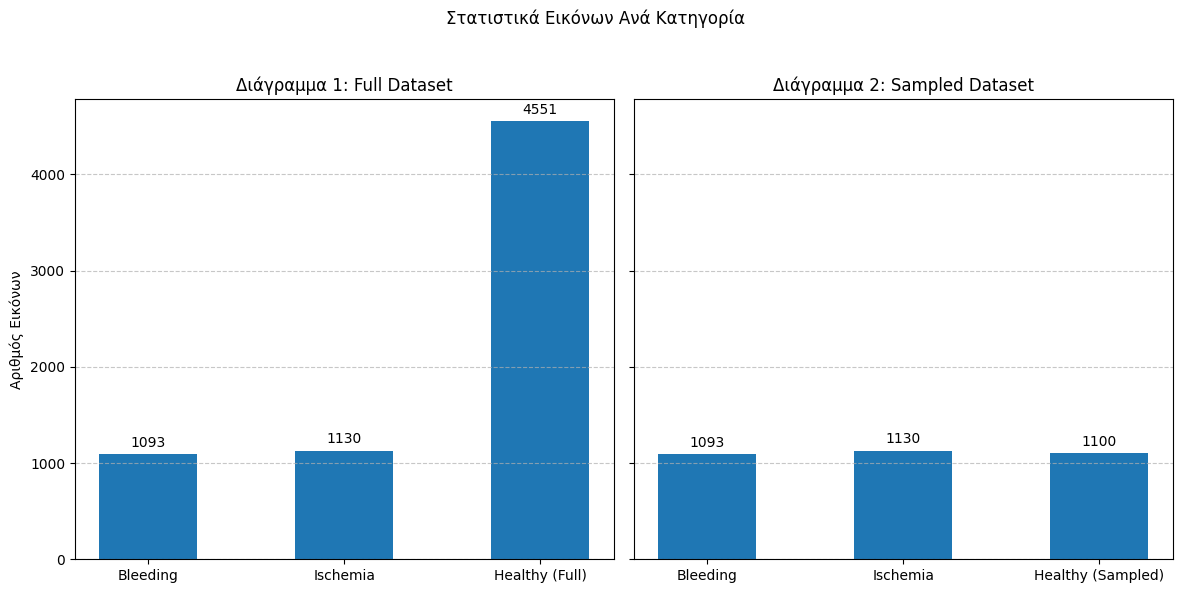

In [ ]:
# Στατιστικά
bleeding_count = len(bleeding_files)
ischemia_count = len(ischemia_files)
healthy_full_count = len(healthy_all)
healthy_sampled_count = len(healthy_files)

# Δεδομένα για τα δύο plots
categories_1 = ['Bleeding', 'Ischemia', 'Healthy (Full)']
values_1 = [bleeding_count, ischemia_count, healthy_full_count]

categories_2 = ['Bleeding', 'Ischemia', 'Healthy (Sampled)']
values_2 = [bleeding_count, ischemia_count, healthy_sampled_count]

colors = ['#1f77b4'] * 3  # Μπλε χρώμα

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Διάγραμμα 1
bars1 = axs[0].bar(categories_1, values_1, color=colors, width=0.5)
axs[0].set_title("Διάγραμμα 1: Full Dataset")
axs[0].set_ylabel("Αριθμός Εικόνων")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1:
    height = bar.get_height()
    axs[0].annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Διάγραμμα 2
bars2 = axs[1].bar(categories_2, values_2, color=colors, width=0.5)
axs[1].set_title("Διάγραμμα 2: Sampled Dataset")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars2:
    height = bar.get_height()
    axs[1].annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.suptitle("Στατιστικά Εικόνων Ανά Κατηγορία")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
def print_class_distribution(labels, label_map, title=""):
    counts = Counter(labels)
    print(f"{title}")
    for label in sorted(counts):
        print(f"    {label_map[label]}: {counts[label]}")

def crop_black_areas(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Convert to uint8 if needed
    image = image.astype(np.uint8)
    original_shape = image.shape  # (height, width)

    # Threshold to find non-black regions
    _, thresh = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        cropped = image.copy()
        cropped_shape = original_shape
    else:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        padding = 10
        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, image.shape[1] - x)
        h = min(h + 2 * padding, image.shape[0] - y)
        cropped = image[y:y+h, x:x+w]
        cropped_shape = cropped.shape

    return cropped

def split_and_save(bleeding_files, ischemia_files, healthy_files):
    output_dir = '/content/stroke_data/split_dataset'
    categories = ['Bleeding', 'Ischemia', 'Healthy']
    category_map = {0: 'Bleeding', 1: 'Ischemia', 2: 'Healthy'}

    # Remove duplicates
    bleeding_files = list(set(bleeding_files))
    ischemia_files = list(set(ischemia_files))
    healthy_files = list(set(healthy_files))

    all_files = bleeding_files + ischemia_files + healthy_files
    labels = [0] * len(bleeding_files) + [1] * len(ischemia_files) + [2] * len(healthy_files)

    print(f"📸 Total unique photos: {len(all_files)}")
    print_class_distribution(labels, category_map, "📊 Σύνολο dataset:")

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_files = [[] for _ in range(5)]
    fold_labels = [[] for _ in range(5)]
    for fold_idx, (_, val_idx) in enumerate(skf.split(all_files, labels)):
        fold_files[fold_idx] = [all_files[i] for i in val_idx]
        fold_labels[fold_idx] = [labels[i] for i in val_idx]
        print(f"\n📂 Fold {fold_idx}: {len(fold_files[fold_idx])} photos")
        print_class_distribution(fold_labels[fold_idx], category_map, f"📊 Fold {fold_idx} class distribution:")

    # Clear output directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    # Create folders for each fold
    for fold_idx in range(5):
        for category in categories:
            os.makedirs(os.path.join(output_dir, f'fold_{fold_idx}', category), exist_ok=True)

    # Copy and crop images to respective folders
    for fold_idx in range(5):
        fold_dir = os.path.join(output_dir, f'fold_{fold_idx}')
        for file_path, label in zip(fold_files[fold_idx], fold_labels[fold_idx]):
            category = category_map[label]
            filename = os.path.basename(file_path)
            dest = os.path.join(fold_dir, category, filename)
            try:
                # Crop the image
                cropped_image = crop_black_areas(file_path)
                # Save the cropped image
                cv2.imwrite(dest, cropped_image)
            except Exception as e:
                print(f"❌ Σφάλμα στο photo {file_path}: {e}")

        # Integrity check
        for category in categories:
            category_path = os.path.join(fold_dir, category)
            num_photos = len([f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            expected = sum(1 for l in fold_labels[fold_idx] if category_map[l] == category)
            if num_photos != expected:
                print(f"❌ Σφάλμα στον φάκελο [Fold {fold_idx}] {category}: "
                      f"Αναμενόμενα {expected} αρχεία, βρέθηκαν {num_photos}")

split_and_save(bleeding_files, ischemia_files, healthy_files)

📸 Total unique photos: 3323
📊 Σύνολο dataset:
    Bleeding: 1093
    Ischemia: 1130
    Healthy: 1100

📂 Fold 0: 665 photos
📊 Fold 0 class distribution:
    Bleeding: 219
    Ischemia: 226
    Healthy: 220

📂 Fold 1: 665 photos
📊 Fold 1 class distribution:
    Bleeding: 219
    Ischemia: 226
    Healthy: 220

📂 Fold 2: 665 photos
📊 Fold 2 class distribution:
    Bleeding: 219
    Ischemia: 226
    Healthy: 220

📂 Fold 3: 664 photos
📊 Fold 3 class distribution:
    Bleeding: 218
    Ischemia: 226
    Healthy: 220

📂 Fold 4: 664 photos
📊 Fold 4 class distribution:
    Bleeding: 218
    Ischemia: 226
    Healthy: 220


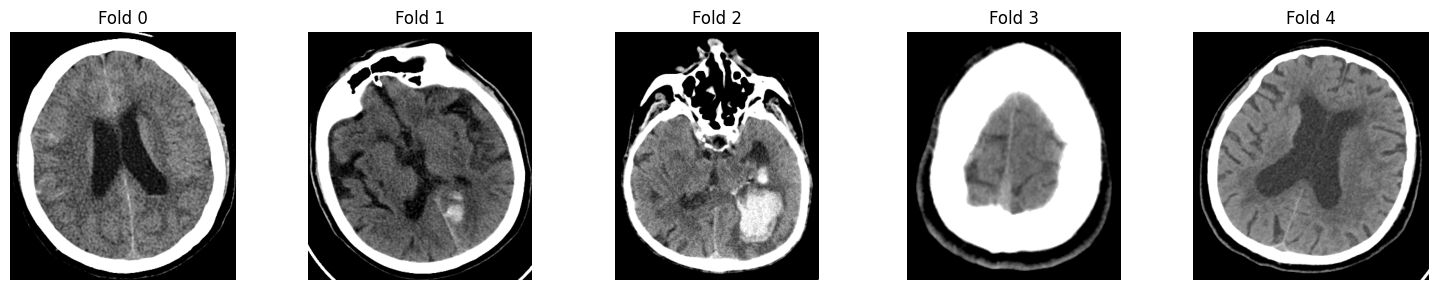

In [ ]:
def display_random_image_from_each_fold(dataset_dir='/content/stroke_data/split_dataset'):
    # Λίστα με τους φακέλους fold (fold_0, fold_1, ..., fold_4)
    folds = [f'fold_{i}' for i in range(5)]
    categories = ['Bleeding', 'Ischemia', 'Healthy']

    # Ρύθμιση του subplot για εμφάνιση 5 εικόνων (1 από κάθε fold)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.flatten()

    for idx, fold in enumerate(folds):
        fold_dir = os.path.join(dataset_dir, fold)
        if not os.path.exists(fold_dir):
            print(f"❌ Ο φάκελος {fold_dir} δεν υπάρχει")
            continue

        # Συλλογή όλων των εικόνων από τις κατηγορίες του fold
        all_images = []
        for category in categories:
            category_dir = os.path.join(fold_dir, category)
            if os.path.exists(category_dir):
                images = [os.path.join(category_dir, f) for f in os.listdir(category_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.extend(images)

        if not all_images:
            print(f"❌ Καμία εικόνα δεν βρέθηκε στο {fold}")
            axes[idx].set_visible(False)
            continue

        # Επιλογή τυχαίας εικόνας
        random_image_path = random.choice(all_images)

        # Φόρτωση και εμφάνιση της εικόνας
        try:
            image = Image.open(random_image_path).convert('L')  # Φόρτωση σε grayscale
            axes[idx].imshow(image, cmap='gray')
            axes[idx].set_title(f'Fold {idx}')
            axes[idx].axis('off')
        except Exception as e:
            print(f"❌ Σφάλμα κατά τη φόρτωση της εικόνας {random_image_path}: {e}")
            axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()


display_random_image_from_each_fold()

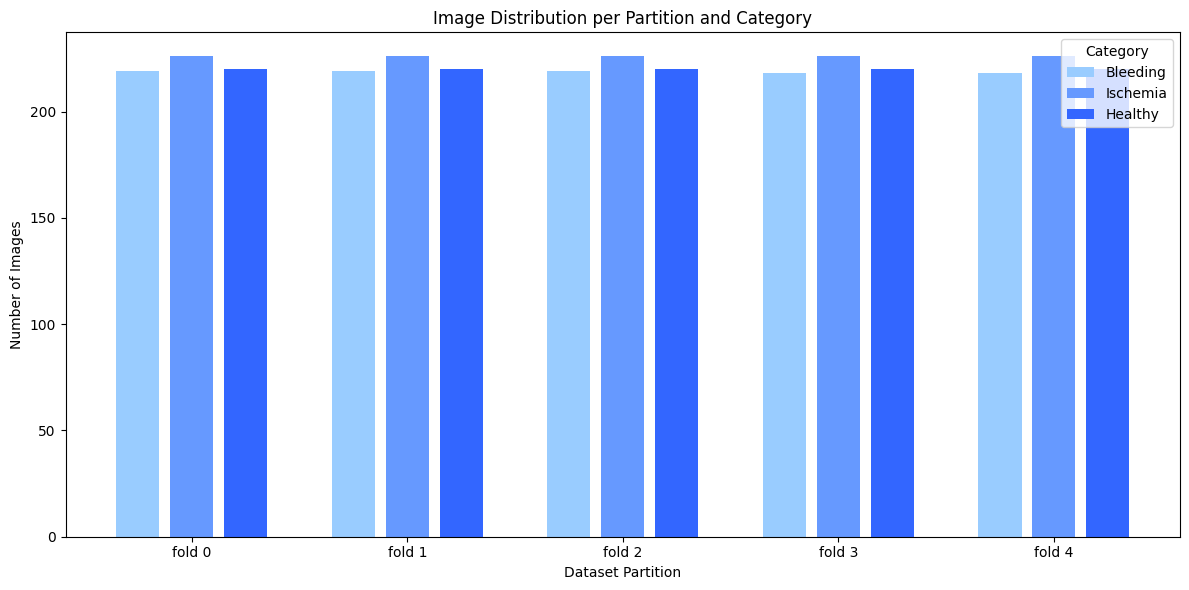

In [ ]:
base_path = '/content/stroke_data/split_dataset'

# Φάκελοι που περιέχουν τα σύνολα δεδομένων
folders = [f'fold_{i}' for i in range(5)]
categories = ['Bleeding', 'Ischemia', 'Healthy']

# Χρώματα (μπλε αποχρώσεις)
colors = ['#99ccff', '#6699ff', '#3366ff']  # Bleeding, Ischemia, Healthy

# Μαζεύουμε τα πλήθη εικόνων
distribution = []
for folder in folders:
    counts = []
    for category in categories:
        category_path = os.path.join(base_path, folder, category)
        count = len([
            f for f in os.listdir(category_path)
            if os.path.isfile(os.path.join(category_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        counts.append(count)
    distribution.append(counts)

distribution = np.array(distribution)

# === Δημιουργία διαγράμματος ===
x = np.arange(len(folders))  # x-άξονας για κάθε group
bar_width = 0.2
spacing = 0.05

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(len(categories)):
    ax.bar(x + (i - 1) * (bar_width + spacing), distribution[:, i], width=bar_width, color=colors[i], label=categories[i])

# Ρυθμίσεις διαγράμματος
ax.set_xticks(x)
ax.set_xticklabels([f.replace('train/', 'Fold ').replace('_', ' ') if 'fold_' in f else f.capitalize() for f in folders])
ax.set_xlabel('Dataset Partition')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution per Partition and Category')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

# **Common Functions and Classes**  

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set up local dataset
local_data_dir = '/content/stroke_data'
if not os.path.exists(local_data_dir):
    shutil.copytree('/content/drive/MyDrive/stroke_data', local_data_dir)
    print(f"Dataset copied to {local_data_dir}")

# --- Stratified Split ---
def stratified_split(dataset, val_ratio):
    labels = []
    for d in dataset.datasets:
        labels.extend(d.labels)
    labels = np.array(labels)
    indices = np.arange(len(labels))

    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(sss.split(indices, labels))

    return Subset(dataset, train_idx), Subset(dataset, val_idx)

def load_fold_data(fold_idx, transform):
    fold_dir = f"{local_data_dir}/split_dataset/fold_{fold_idx}"
    return CustomDataset(fold_dir, transform=transform)

def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    losses, preds, targets = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item() * images.size(0))
            preds.extend(outputs.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    avg_loss = sum(losses) / len(dataloader.dataset)
    return avg_loss, accuracy_score(targets, preds), precision_score(targets, preds, average='weighted'), recall_score(targets, preds, average='weighted'), f1_score(targets, preds, average='weighted'), confusion_matrix(targets, preds)

def print_class_distribution(dataset, name):
    if isinstance(dataset, Subset):
        labels = [dataset.dataset[idx][1] for idx in dataset.indices]
    elif isinstance(dataset, Dataset):
        labels = [dataset[i][1] for i in range(len(dataset))]
    else:
        raise ValueError("Unsupported dataset type")

    label_names = {0: 'Bleeding', 1: 'Ischemia', 2: 'Healthy'}
    counts = Counter(labels)
    print(f"\n{name.upper()} SET CLASS DISTRIBUTION:")
    for label, count in sorted(counts.items()):
        print(f"  {label_names[label]}: {count}")

def compute_class_weights(dataset):
    label_counts = Counter()
    for d in dataset.datasets:
        label_counts.update(d.labels)
    total = sum(label_counts.values())
    weights = [total / label_counts[i] for i in range(3)]
    weights[0] *= 0.8  # reduce Bleeding
    norm_weights = [w / sum(weights) for w in weights]
    return torch.tensor(norm_weights).float()


def print_class_distribution(dataset, name):
    if isinstance(dataset, Subset):
        labels = [dataset.dataset[idx][1] for idx in dataset.indices]
    elif isinstance(dataset, Dataset):
        labels = [dataset[i][1] for i in range(len(dataset))]
    else:
        raise ValueError("Unsupported dataset type")

    label_names = {0: 'Bleeding', 1: 'Ischemia', 2: 'Healthy'}
    counts = Counter(labels)
    print(f"\n{name.upper()} SET CLASS DISTRIBUTION:")
    for label, count in sorted(counts.items()):
        print(f"  {label_names[label]}: {count}")

#Loss Curve and Confusion Matrix
def plot_confusion_matrix(cm, model_idx, set_name, base_path):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bleeding', 'Ischemia', 'Healthy'],
                yticklabels=['Bleeding', 'Ischemia', 'Healthy'])
    plt.title(f'Case {model_idx} - {set_name.capitalize()} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cm_filename = f"model_{model_idx}_{set_name}_confusion_matrix.png"
    plt.savefig(os.path.join(base_path, cm_filename))
    plt.show()
    plt.close()


def save_metrics_to_csv(model, loaders, device, criterion, model_idx, base_path):
    all_metrics = []
    for name, loader in loaders.items():
        loss, acc, prec, rec, f1, cm = evaluate_model(model, loader, device, criterion)
        all_metrics.append({
            'Model': model_idx,
            'Set': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Score': f1
        })

    metrics_path = os.path.join(base_path, "metrics_combined.csv")
    df_metrics = pd.DataFrame(all_metrics)
    if os.path.exists(metrics_path):
        df_metrics.to_csv(metrics_path, mode='a', index=False, header=False)
    else:
        df_metrics.to_csv(metrics_path, index=False)

    return all_metrics

class CustomCallback:
    def __init__(self, model, optimizer, patience, stop_patience, threshold, factor, epochs):
        self.model = model
        self.optimizer = optimizer
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.epochs = epochs
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = None
        self.start_time = None

    def on_train_begin(self):
        print(f"\n{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<11} {'Val Loss':<10} {'Val Acc':<9} {'LR':<10}")

    def on_epoch_end(self, epoch, train_loss, val_loss, val_acc):
        current_lr = self.optimizer.param_groups[0]['lr']

        min_epochs = 10
        train_acc = self.highest_tracc

        if val_loss < self.lowest_vloss:
            self.lowest_vloss = val_loss
            self.best_weights = self.model.state_dict()
            self.count = 0
            self.stop_count = 0
            self.best_epoch = epoch + 1
        else:
            if epoch >= min_epochs:
                if self.count >= self.patience - 1:
                    current_lr = current_lr * self.factor
                    self.optimizer.param_groups[0]['lr'] = current_lr
                    self.count = 0
                    self.stop_count += 1
                else:
                    self.count += 1
            if train_acc > self.highest_tracc:
                self.highest_tracc = train_acc

        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc*100:<11.2f} {val_loss:<10.4f} {val_acc*100:<9.2f} {current_lr:<10.6f}")

        if epoch >= min_epochs and self.stop_count > self.stop_patience - 1:
            print(f'training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement')
            return True
        return False

Mounted at /content/drive


# **ResNet50**

In [ ]:
def resnet50_model(num_classes=3):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = {'Bleeding': 0, 'Ischemia': 1, 'Healthy': 2}
        for category in self.label_map:
            category_dir = os.path.join(root_dir, category)
            for fname in os.listdir(category_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(category_dir, fname))
                    self.labels.append(self.label_map[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        image = np.array(image)
        image = np.stack([image]*3, axis=-1)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, self.labels[idx]


def train_model(model_idx, test_fold, train_folds, base_path, device, lr=16e-5):
    test_dataset = load_fold_data(test_fold, val_transform)
    train_val_datasets = [load_fold_data(i, train_transform) for i in train_folds]
    train_val_dataset = ConcatDataset(train_val_datasets)

    train_dataset, val_dataset = stratified_split(train_val_dataset, val_ratio=0.15)

    print_class_distribution(train_dataset, "Train")
    print_class_distribution(val_dataset, "Validation")

    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = resnet50_model(num_classes=3).to(device)
    class_weights = compute_class_weights(train_val_dataset).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    callback = CustomCallback(model, optimizer, patience=3, stop_patience=5, threshold=0.9, factor=0.5, epochs=40)


    callback.on_train_begin()
    for epoch in range(40):
        model.train()
        train_loss = 0
        train_preds, , = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)

        val_loss, val_acc, val_prec, val_rec, val_f1, _ = evaluate_model(model, val_loader, device, criterion)

        callback.highest_tracc = train_acc
        stop = callback.on_epoch_end(epoch, train_loss, val_loss, val_acc)
        if stop:
            break

    if callback.best_weights is not None:
        model.load_state_dict(callback.best_weights)

    model_name = f"resnet50_model_{model_idx}_final.pth"
    model_path = os.path.join(base_path, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"Saved final model to {model_path}")

    loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    save_metrics_to_csv(model, loaders, device, criterion, model_idx, base_path)

def train_all_models():
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_path = "/content/drive/My Drive/Neural Networks/ResNet50"
    os.makedirs(base_path, exist_ok=True)
    for model_idx in range(5):
        print(f"\n[Model {model_idx}] Training with Fold {model_idx} as test")
        test_fold = model_idx
        train_folds = [i for i in range(5) if i != model_idx]
        train_model(model_idx, test_fold, train_folds, base_path, device)

if __name__ == "__main__":
    train_all_models()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



[Model 0] Training with Fold 0 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]



Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9658       51.88       0.7179     69.42     0.000160  
2      0.7769       65.34       0.6476     72.68     0.000160  
3      0.7265       67.60       0.6165     74.44     0.000160  
4      0.6596       72.20       0.5585     76.19     0.000160  
5      0.5874       74.50       0.4524     80.70     0.000160  
6      0.5562       76.58       0.5059     75.94     0.000160  
7      0.5511       77.91       0.4237     82.46     0.000160  
8      0.4977       80.21       0.3583     85.71     0.000160  
9      0.4576       81.85       0.3807     84.96     0.000160  
10     0.4420       82.96       0.4450     84.21     0.000160  
11     0.4333       83.84       0.3381     86.22     0.000160  
12     0.4016       84.20       0.3827     83.21     0.000160  
13     0.3926       85.44       0.3849     84.21     0.000160  
14     0.3705       85.97       0.3655     85.21     0.000080  
15     0.3001       88.80       0.2822 


[Model 1] Training with Fold 1 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9757       50.60       0.8013     69.17     0.000160  
2      0.7548       66.18       0.6359     73.18     0.000160  
3      0.6863       72.33       0.5663     74.44     0.000160  
4      0.6205       73.97       0.4625     81.20     0.000160  
5      0.5431       77.56       0.4350     80.70     0.000160  
6      0.5172       78.49       0.3862     83.46     0.000160  
7      0.4628       81.94       0.4117     83.46     0.000160  
8      0.4343       81.94       0.3452     86.47     0.000160  
9      0.4302       82.82       0.3513     86.47     0.000160  
10     0.3889       85.13       0.3502     86.47     0.000160  
11     0.3809       85.75       0.3721     85.96     0.000160  
12     0.3648       86.54     


[Model 2] Training with Fold 2 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      1.0239       48.21       0.7994     61.90     0.000160  
2      0.8093       62.11       0.6178     75.69     0.000160  
3      0.7192       68.13       0.5030     79.45     0.000160  
4      0.6310       73.00       0.4946     79.45     0.000160  
5      0.5793       76.94       0.4083     83.71     0.000160  
6      0.5190       79.55       0.3491     85.21     0.000160  
7      0.4880       81.01       0.3427     84.46     0.000160  
8      0.4627       80.92       0.3374     87.72     0.000160  
9      0.4160       82.78       0.2694     89.22     0.000160  
10     0.3991       84.37       0.2660     89.97     0.000160  
11     0.3799       85.35       0.3936     86.22     0.000160  
12     0.3697       85.61     


[Model 3] Training with Fold 3 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 744
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9759       50.80       0.8416     63.66     0.000160  
2      0.7671       65.00       0.6286     70.68     0.000160  
3      0.6493       71.81       0.4844     79.70     0.000160  
4      0.6132       74.20       0.5214     77.69     0.000160  
5      0.5480       78.32       0.3918     83.21     0.000160  
6      0.5221       79.07       0.4321     81.95     0.000160  
7      0.4678       81.19       0.3927     82.71     0.000160  
8      0.4166       82.70       0.3884     84.21     0.000160  
9      0.4175       83.01       0.3150     87.22     0.000160  
10     0.3839       85.22       0.3512     88.72     0.000160  
11     0.3392       86.15       0.3128     88.97     0.000160  
12     0.3490       86.11     


[Model 4] Training with Fold 4 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 744
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9773       50.13       0.7867     65.91     0.000160  
2      0.7718       64.96       0.5887     74.69     0.000160  
3      0.6830       70.49       0.5991     73.93     0.000160  
4      0.6315       74.20       0.4884     79.95     0.000160  
5      0.5423       77.30       0.4401     84.21     0.000160  
6      0.5086       79.38       0.4655     81.45     0.000160  
7      0.4852       80.62       0.3788     86.22     0.000160  
8      0.4366       81.90       0.4163     82.96     0.000160  
9      0.4359       82.70       0.4929     78.70     0.000160  
10     0.4253       83.14       0.3350     86.97     0.000160  
11     0.4030       84.60       0.3505     86.97     0.000160  
12     0.3409       86.77     

#**EfficientNet-B0**

In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.GaussNoise(p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.2),
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = {'Bleeding': 0, 'Ischemia': 1, 'Healthy': 2}
        for category in self.label_map:
            category_dir = os.path.join(root_dir, category)
            for fname in os.listdir(category_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(category_dir, fname))
                    self.labels.append(self.label_map[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, self.labels[idx]


def efficientnet_b0_model(num_classes=3):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(model.classifier[1].in_features, momentum=0.99, eps=0.001),
        nn.Linear(model.classifier[1].in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model

def train_model(model_idx, test_fold, train_folds, base_path, device, lr=0.0002):
    test_dataset = load_fold_data(test_fold, val_transform)
    train_val_datasets = [load_fold_data(i, train_transform) for i in train_folds]
    train_val_dataset = ConcatDataset(train_val_datasets)

    train_dataset, val_dataset = stratified_split(train_val_dataset, val_ratio=0.15)

    print_class_distribution(train_dataset, "Train")
    print_class_distribution(val_dataset, "Validation")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    model = efficientnet_b0_model(num_classes=3)
    for param in model.parameters():
        param.requires_grad = True

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=compute_class_weights(train_val_dataset).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    callback = CustomCallback(model, optimizer, patience=3, stop_patience=5, threshold=0.9, factor=0.5, epochs=40)
    train_losses = []
    val_losses = []
    metrics = []

    callback.on_train_begin()
    for epoch in range(40):
        model.train()
        train_loss_sum = 0
        train_preds, train_targets = [], []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            l2_reg = sum(torch.norm(param, 2) for param in model.classifier.parameters()) * 0.001
            l1_reg = sum(torch.norm(param, 1) for param in model.classifier.parameters()) * 0.001
            total_loss = loss + l2_reg + l1_reg
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss_sum += loss.item() * images.size(0)
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss = train_loss_sum / len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_losses.append(train_loss)

        val_loss, val_acc, val_prec, val_rec, val_f1, cm = evaluate_model(model, val_loader, device, criterion)
        val_losses.append(val_loss)

        callback.highest_tracc = train_acc
        stop = callback.on_epoch_end(epoch, train_loss, val_loss, val_acc)
        metrics.append({
            'Epoch': epoch + 1,
            'Train_Loss': train_loss,
            'Val_Loss': val_loss,
            'Val_Accuracy': val_acc,
            'Val_Precision': val_prec,
            'Val_Recall': val_rec,
            'Val_F1_Score': val_f1,
        })
        if stop:
            break

    final_model_path = os.path.join(base_path, f"efficientnet_b0_model_{model_idx}_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model to {final_model_path}")

    metrics_df = pd.DataFrame(metrics).assign(Model=model_idx)
    metrics_csv = os.path.join(base_path, f"loss_model_{model_idx}.csv")
    metrics_df.to_csv(metrics_csv, index=False)
    print(f"Saved metrics to {metrics_csv}")

    model.load_state_dict(callback.best_weights if callback.best_weights else model.state_dict())

    loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    save_metrics_to_csv(model, loaders, device, criterion, model_idx, base_path)


def train_all_models():
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_path = "/content/drive/My Drive/Neural Networks/EfficientNetB0"
    os.makedirs(base_path, exist_ok=True)
    for model_idx in range(5):
        print(f"\n[Model {model_idx}] Training with Fold {model_idx} as test")
        test_fold = model_idx
        train_folds = [i for i in range(5) if i != model_idx]
        train_model(model_idx, test_fold, train_folds, base_path, device)

if __name__ == "__main__":
    train_all_models()


[Model 0] Training with Fold 0 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132


100%|██████████| 20.5M/20.5M [00:00<00:00, 196MB/s]



Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9079       56.26       0.6974     68.92     0.000200  
2      0.6358       70.92       0.6339     70.93     0.000200  
3      0.5465       75.48       0.5132     77.19     0.000200  
4      0.4823       80.21       0.4675     81.45     0.000200  
5      0.4398       81.94       0.4435     81.20     0.000200  
6      0.4081       82.82       0.4897     81.70     0.000200  
7      0.3924       84.77       0.3671     85.96     0.000200  
8      0.3580       85.79       0.4499     82.71     0.000200  
9      0.3381       86.59       0.3767     85.71     0.000200  
10     0.3184       88.05       0.3501     86.97     0.000200  
11     0.2997       89.42       0.3210     88.22     0.000200  
12     0.2983       89.42       0.3329     87.47     0.000200  
13     0.2766       90.04       0.3052     87.72     0.000200  
14     0.2697       89.69       0.2865     88.97     0.000200  
15     0.2676       90.53       0.3114 


[Model 1] Training with Fold 1 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9385       52.90       0.6785     67.67     0.000200  
2      0.6790       68.79       0.5848     73.18     0.000200  
3      0.6038       72.91       0.5759     74.44     0.000200  
4      0.5297       76.89       0.4841     78.20     0.000200  
5      0.4603       79.95       0.4913     80.70     0.000200  
6      0.4472       81.32       0.4341     81.45     0.000200  
7      0.4071       82.87       0.4332     82.21     0.000200  
8      0.3953       83.89       0.3610     87.22     0.000200  
9      0.3804       85.21       0.3558     84.71     0.000200  
10     0.3522       87.07       0.3824     86.72     0.000200  
11     0.3248       88.53       0.3424     88.22     0.000200  
12     0.3125       88.76     


[Model 2] Training with Fold 2 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.8948       54.63       0.6126     74.94     0.000200  
2      0.6233       72.07       0.6008     73.68     0.000200  
3      0.5012       78.66       0.4327     83.46     0.000200  
4      0.4314       82.87       0.4567     82.96     0.000200  
5      0.3918       83.98       0.3866     84.71     0.000200  
6      0.3526       86.94       0.3453     86.47     0.000200  
7      0.3658       85.79       0.3452     86.47     0.000200  
8      0.3314       87.61       0.3435     87.97     0.000200  
9      0.3054       89.38       0.3431     86.22     0.000200  
10     0.2680       91.32       0.3262     87.97     0.000200  
11     0.2748       89.95       0.2764     90.48     0.000200  
12     0.2548       91.54     


[Model 3] Training with Fold 3 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 744
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.9357       52.65       0.6596     71.93     0.000200  
2      0.6459       71.73       0.5007     80.70     0.000200  
3      0.5338       76.28       0.4310     83.71     0.000200  
4      0.4728       79.91       0.4256     83.96     0.000200  
5      0.4373       82.96       0.4103     83.96     0.000200  
6      0.3949       84.69       0.3296     87.47     0.000200  
7      0.3671       86.33       0.3347     88.47     0.000200  
8      0.3452       87.39       0.2977     90.23     0.000200  
9      0.3425       87.08       0.3030     89.22     0.000200  
10     0.3203       88.19       0.3307     88.47     0.000200  
11     0.3076       88.85       0.2607     93.23     0.000200  
12     0.2627       90.71     


[Model 4] Training with Fold 4 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 744
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.8993       54.96       0.5930     73.43     0.000200  
2      0.6482       70.22       0.4970     79.45     0.000200  
3      0.5493       75.84       0.4149     84.21     0.000200  
4      0.4848       78.89       0.4111     82.46     0.000200  
5      0.4643       80.71       0.3484     84.71     0.000200  
6      0.4109       83.81       0.3039     89.47     0.000200  
7      0.3796       85.04       0.2903     89.47     0.000200  
8      0.3290       88.45       0.2911     87.47     0.000200  
9      0.3416       87.17       0.2599     90.48     0.000200  
10     0.3146       88.89       0.2689     90.48     0.000200  
11     0.3035       89.12       0.3134     87.47     0.000200  
12     0.3118       88.76     

#**DensNet121***

In [ ]:

# Define transforms for grayscale
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Custom Dataset for grayscale
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = {'Bleeding': 0, 'Ischemia': 1, 'Healthy': 2}
        for category in self.label_map:
            category_dir = os.path.join(root_dir, category)
            for fname in os.listdir(category_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(category_dir, fname))
                    self.labels.append(self.label_map[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        image = np.array(image)[:, :, np.newaxis]  # Shape: (H, W, 1)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, self.labels[idx]

# DenseNet-121 model for grayscale
def densenet121_model(num_classes=3):
    model = models.densenet121(weights='IMAGENET1K_V1')
    # Modify first conv layer for 1-channel input
    original_conv0_weight = model.features.conv0.weight  # Shape: (64, 3, 7, 7)
    new_conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    with torch.no_grad():
        new_conv0.weight = nn.Parameter(original_conv0_weight[:, 0:1, :, :])  # Shape: (64, 1, 7, 7)
    model.features.conv0 = new_conv0
    # Modify classifier
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Train model
def train_model(model_idx, test_fold, train_folds, base_path, device, lr=0.00008):
    test_dataset = load_fold_data(test_fold, val_transform)
    train_val_datasets = [load_fold_data(i, train_transform) for i in train_folds]
    train_val_dataset = ConcatDataset(train_val_datasets)

    train_dataset, val_dataset = stratified_split(train_val_dataset, val_ratio=0.15)

    print_class_distribution(train_dataset, "Train")
    print_class_distribution(val_dataset, "Validation")

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = densenet121_model(num_classes=3).to(device)
    class_weights = compute_class_weights(train_val_dataset).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    callback = CustomCallback(model, optimizer, patience=3, stop_patience=5, threshold=0.9, factor=0.5, epochs=40)

    train_losses, val_losses = [], []

    callback.on_train_begin()
    for epoch in range(40):
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)  # Fixed bug
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_losses.append(train_loss)

        val_loss, val_acc, val_prec, val_rec, val_f1, _ = evaluate_model(model, val_loader, device, criterion)
        val_losses.append(val_loss)

        callback.highest_tracc = train_acc
        stop = callback.on_epoch_end(epoch, train_loss, val_loss, val_acc)
        if stop:
            break

    if callback.best_weights is not None:
        model.load_state_dict(callback.best_weights)

    model_name = f"densenet121_model_{model_idx}_final.pth"
    model_path = os.path.join(base_path, model_name)
    torch.save(model.state_dict(), model_path)

    loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    save_metrics_to_csv(model, loaders, device, criterion, model_idx, base_path)

# Train all models
def train_all_models():
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_path = "/content/drive/My Drive/Neural Networks/DensNet121"
    os.makedirs(base_path, exist_ok=True)
    for model_idx in range(5):
        print(f"\n[Model {model_idx}] Training with Fold {model_idx} as test")
        test_fold = model_idx
        train_folds = [i for i in range(5) if i != model_idx]
        train_model(model_idx, test_fold, train_folds, base_path, device)

if __name__ == "__main__":
    train_all_models()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



[Model 0] Training with Fold 0 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.8062       62.77       0.5219     79.95     0.000080  
2      0.4877       81.27       0.4381     83.21     0.000080  
3      0.4354       82.91       0.4199     82.71     0.000080  
4      0.3502       87.07       0.3682     85.96     0.000080  
5      0.3261       88.09       0.4200     84.46     0.000080  
6      0.2786       89.82       0.3407     86.72     0.000080  
7      0.2561       90.08       0.3426     86.97     0.000080  
8      0.2636       90.44       0.2967     89.22     0.000080  
9      0.2061       92.39       0.3184     88.97     0.000080  
10     0.2023       92.39       0.4121     85.21     0.000080  
11     0.1906       92.74       0.3360     88.97     0.000080  
12     0.1961       93.18     


[Model 1] Training with Fold 1 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.7937       63.88       0.5391     78.95     0.000080  
2      0.4985       80.04       0.4832     80.20     0.000080  
3      0.4149       84.06       0.3690     85.96     0.000080  
4      0.3627       86.41       0.3782     85.46     0.000080  
5      0.2987       89.77       0.3991     83.21     0.000080  
6      0.2692       90.26       0.3335     88.97     0.000080  
7      0.2496       90.97       0.3082     87.72     0.000080  
8      0.2544       90.66       0.3155     88.72     0.000080  
9      0.2289       91.81       0.3236     87.72     0.000080  
10     0.2094       92.34       0.3065     88.47     0.000080  
11     0.1819       93.14       0.2976     89.22     0.000080  
12     0.1993       92.83     


[Model 2] Training with Fold 2 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 743
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.8114       63.26       0.6053     78.95     0.000080  
2      0.4913       80.04       0.5335     75.44     0.000080  
3      0.4310       83.40       0.3694     85.46     0.000080  
4      0.3418       86.63       0.3562     85.96     0.000080  
5      0.3203       88.09       0.4180     86.22     0.000080  
6      0.2839       89.69       0.3040     88.97     0.000080  
7      0.2871       89.02       0.2917     88.72     0.000080  
8      0.2456       90.08       0.3445     88.22     0.000080  
9      0.2395       90.84       0.2959     87.47     0.000080  
10     0.1681       93.80       0.2653     91.23     0.000080  
11     0.1897       93.32       0.2825     90.48     0.000080  
12     0.2013       92.52     


[Model 3] Training with Fold 3 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 744
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.7895       64.51       0.5118     80.20     0.000080  
2      0.4987       79.96       0.4147     82.71     0.000080  
3      0.4181       84.34       0.3888     84.71     0.000080  
4      0.3239       87.92       0.3869     85.46     0.000080  
5      0.3126       88.50       0.3277     87.47     0.000080  
6      0.2856       89.29       0.2749     89.22     0.000080  
7      0.2429       91.33       0.2753     89.97     0.000080  
8      0.2157       92.79       0.3393     87.72     0.000080  
9      0.1929       93.45       0.2792     88.72     0.000080  
10     0.1987       92.65       0.3169     88.97     0.000080  
11     0.2019       92.57       0.2509     90.98     0.000080  
12     0.1646       94.25     


[Model 4] Training with Fold 4 as test

TRAIN SET CLASS DISTRIBUTION:
  Bleeding: 744
  Ischemia: 768
  Healthy: 748

VALIDATION SET CLASS DISTRIBUTION:
  Bleeding: 131
  Ischemia: 136
  Healthy: 132

Epoch  Train Loss   Train Acc   Val Loss   Val Acc   LR        
1      0.8439       61.11       0.5833     75.69     0.000080  
2      0.5016       79.91       0.4017     84.96     0.000080  
3      0.4132       84.03       0.3600     84.46     0.000080  
4      0.3503       86.28       0.3432     87.97     0.000080  
5      0.3113       88.23       0.3608     85.46     0.000080  
6      0.2776       89.69       0.2878     90.73     0.000080  
7      0.2578       90.18       0.3452     86.47     0.000080  
8      0.2414       90.44       0.2979     89.22     0.000080  
9      0.2175       91.99       0.2465     91.73     0.000080  
10     0.1940       92.61       0.2901     88.47     0.000080  
11     0.1659       93.32       0.2957     89.72     0.000080  
12     0.1698       93.89     

#**Confusion Matrices**

In [ ]:
def print_confusion_matrixes(arch_name, model_dir, model_fn, val_transform, load_fold_data, evaluate_model, save_metrics_to_csv):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    print(f"🧠 Αρχιτεκτονική: {arch_name.upper()}")

    for i in range(5):
        print(f"\n🔍 Αξιολόγηση Μοντέλου {i} (Fold {i})")

        model = model_fn(num_classes=3)
        model_path = os.path.join(model_dir, f"model_{i}_final.pth")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)

        test_dataset = load_fold_data(i, val_transform)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

        loss, acc, prec, rec, f1, cm = evaluate_model(model, test_loader, device, criterion)

        print(f"Accuracy: {acc:.6f} | Precision: {prec:.6f} | Recall: {rec:.6f} | F1: {f1:.6f}")

        # Plot confusion matrix inside this function:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Bleeding', 'Ischemia', 'Healthy'],
                    yticklabels=['Bleeding', 'Ischemia', 'Healthy'])
        plt.title(f'Case {i} - Test Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        cm_filename = f"model_{i}_test_confusion_matrix.png"
        plt.savefig(os.path.join(model_dir, cm_filename))
        plt.show()
        plt.close()

        save_metrics_to_csv(model, {'test': test_loader}, device, criterion, model_idx=i, base_path=model_dir)


Confusion matrix for each ResNet50 model

🧠 Αρχιτεκτονική: RESNET50

🔍 Αξιολόγηση Μοντέλου 0 (Fold 0)
Accuracy: 0.965414 | Precision: 0.966184 | Recall: 0.965414 | F1: 0.965506


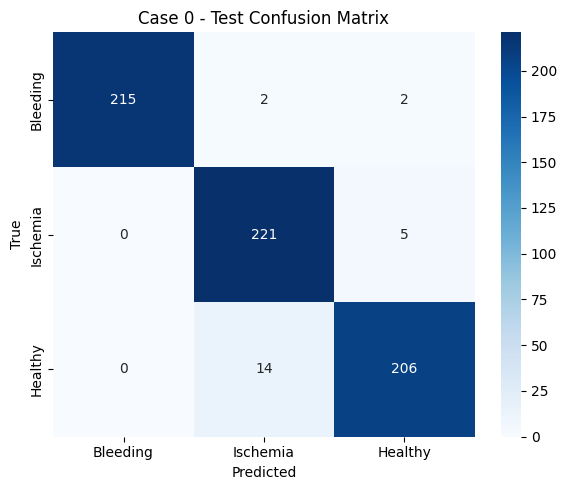


🔍 Αξιολόγηση Μοντέλου 1 (Fold 1)
Accuracy: 0.959398 | Precision: 0.959893 | Recall: 0.959398 | F1: 0.959528


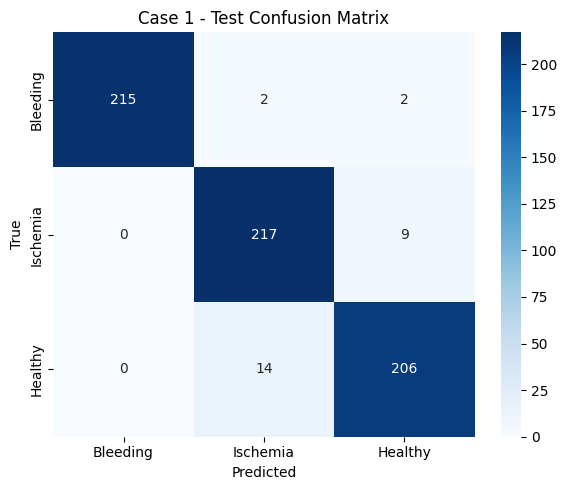


🔍 Αξιολόγηση Μοντέλου 2 (Fold 2)
Accuracy: 0.971429 | Precision: 0.971746 | Recall: 0.971429 | F1: 0.971449


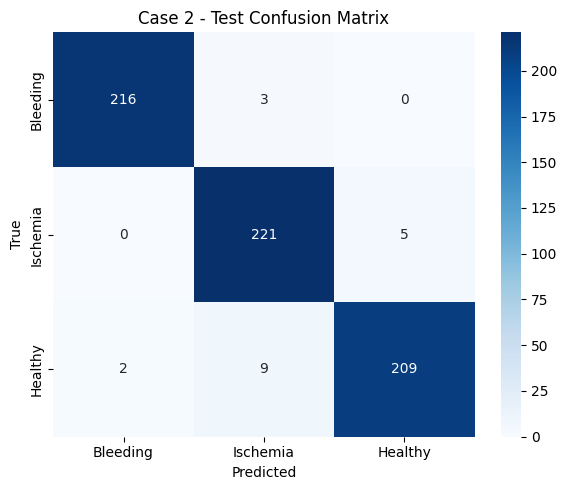


🔍 Αξιολόγηση Μοντέλου 3 (Fold 3)
Accuracy: 0.960843 | Precision: 0.961025 | Recall: 0.960843 | F1: 0.960835


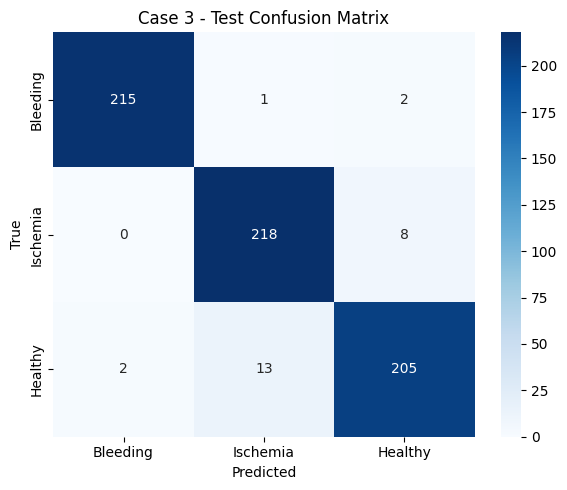


🔍 Αξιολόγηση Μοντέλου 4 (Fold 4)
Accuracy: 0.956325 | Precision: 0.956437 | Recall: 0.956325 | F1: 0.956254


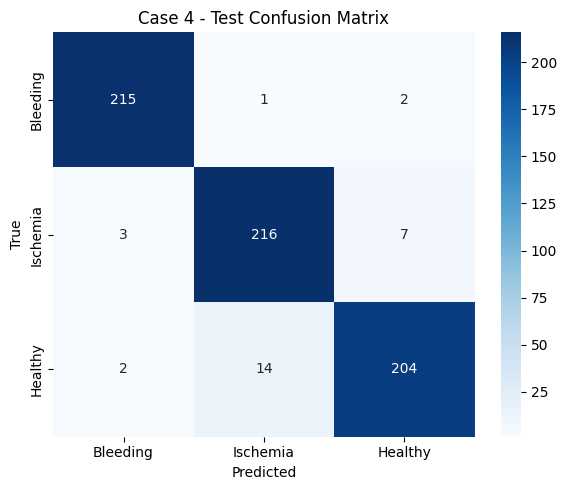

In [ ]:
print_confusion_matrixes(
    arch_name="resnet50",
    model_dir="/content/drive/My Drive/Neural Networks/ResNet50",
    model_fn=resnet50_model,
    val_transform=val_transform,
    load_fold_data=load_fold_data,
    evaluate_model=evaluate_model,
    save_metrics_to_csv=save_metrics_to_csv
)

Confucion Matrix for each EfficientNet-B0 model

🧠 Αρχιτεκτονική: EFFICIENTNET_B0

🔍 Αξιολόγηση Μοντέλου 0 (Fold 0)
Accuracy: 0.960902 | Precision: 0.962772 | Recall: 0.960902 | F1: 0.960954


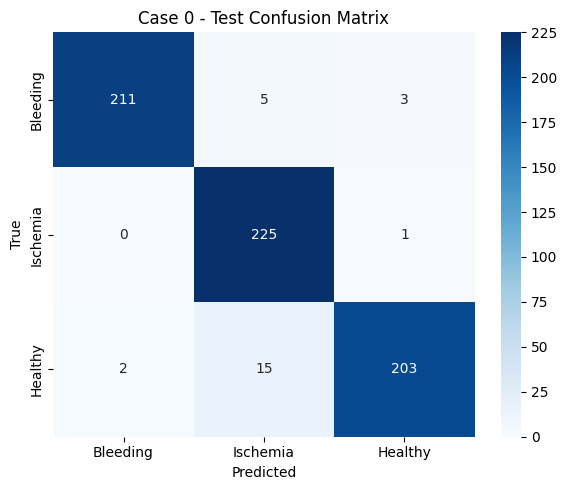


🔍 Αξιολόγηση Μοντέλου 1 (Fold 1)
Accuracy: 0.971429 | Precision: 0.972057 | Recall: 0.971429 | F1: 0.971449


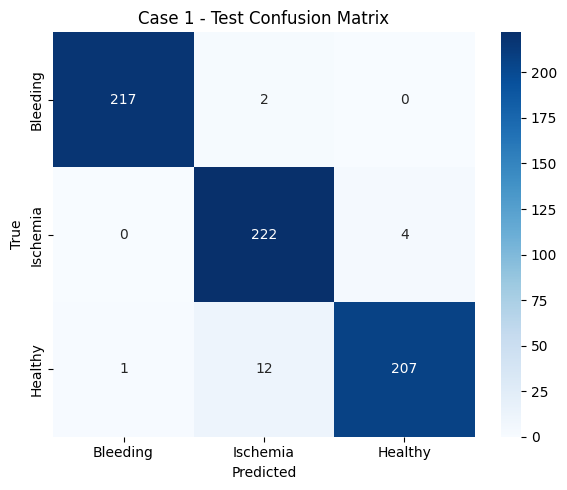


🔍 Αξιολόγηση Μοντέλου 2 (Fold 2)
Accuracy: 0.977444 | Precision: 0.977577 | Recall: 0.977444 | F1: 0.977468


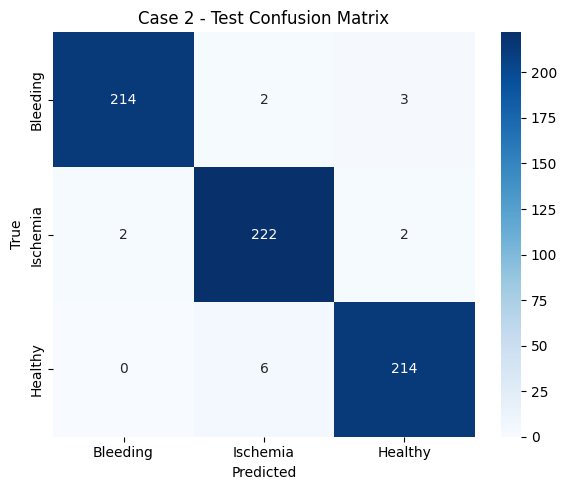


🔍 Αξιολόγηση Μοντέλου 3 (Fold 3)
Accuracy: 0.986446 | Precision: 0.986462 | Recall: 0.986446 | F1: 0.986424


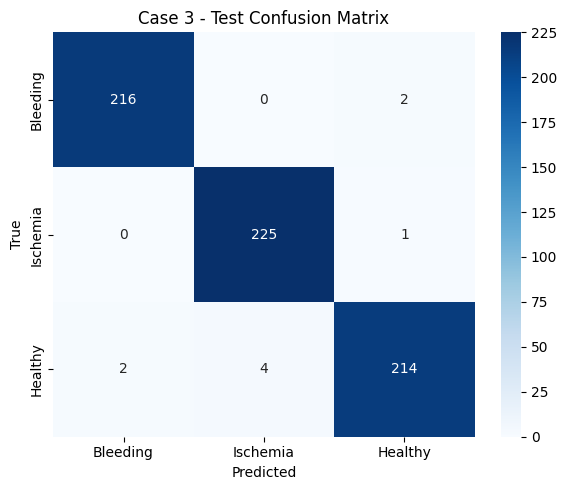


🔍 Αξιολόγηση Μοντέλου 4 (Fold 4)
Accuracy: 0.960843 | Precision: 0.962450 | Recall: 0.960843 | F1: 0.960902


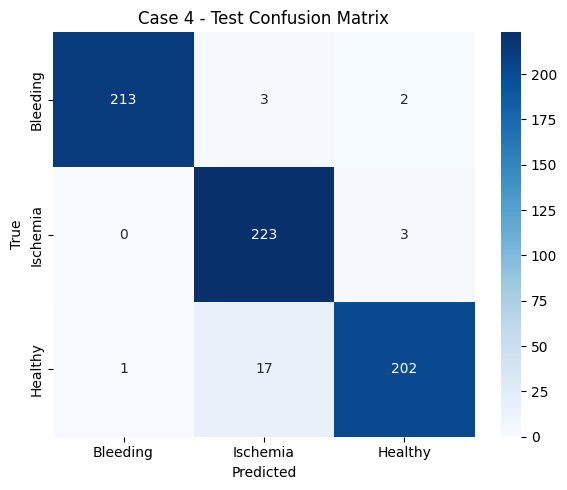

In [ ]:
print_confusion_matrixes(
    arch_name="efficientnet_b0",
    model_dir="/content/drive/My Drive/Neural Networks/EfficientNetB0",
    model_fn=efficientnet_b0_model,
    val_transform=val_transform,
    load_fold_data=load_fold_data,
    evaluate_model=evaluate_model,
    save_metrics_to_csv=save_metrics_to_csv
)

Confucion Matrix for each DensNet121 model

🧠 Αρχιτεκτονική: DENSNET121

🔍 Αξιολόγηση Μοντέλου 0 (Fold 0)
Accuracy: 0.968421 | Precision: 0.969032 | Recall: 0.968421 | F1: 0.968532


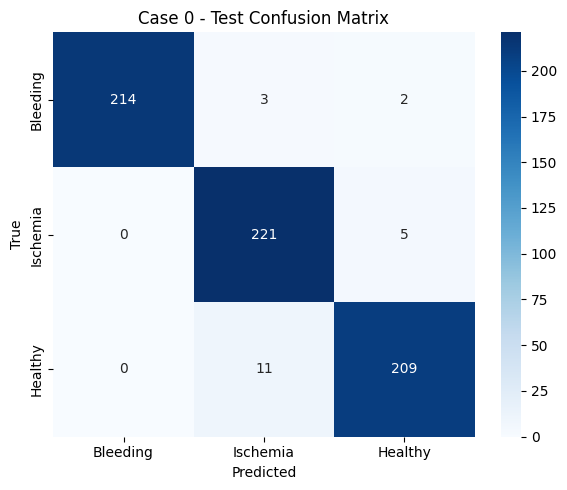


🔍 Αξιολόγηση Μοντέλου 1 (Fold 1)
Accuracy: 0.963910 | Precision: 0.964185 | Recall: 0.963910 | F1: 0.964005


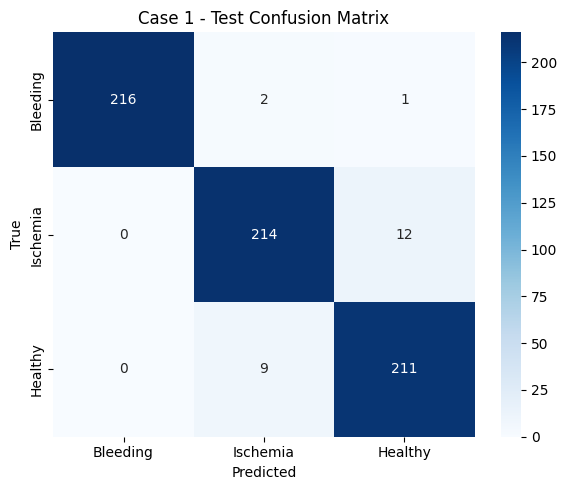


🔍 Αξιολόγηση Μοντέλου 2 (Fold 2)
Accuracy: 0.971429 | Precision: 0.971815 | Recall: 0.971429 | F1: 0.971495


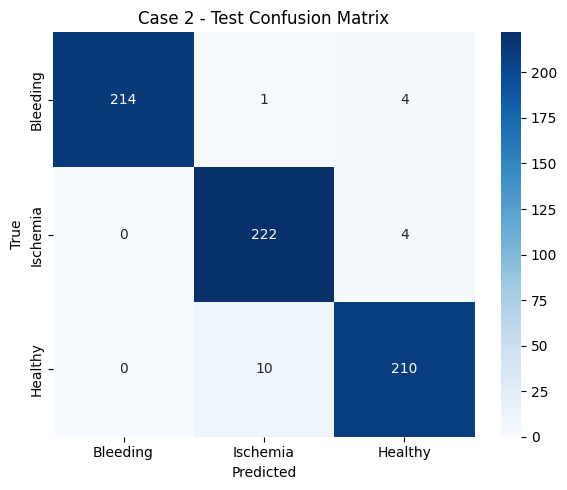


🔍 Αξιολόγηση Μοντέλου 3 (Fold 3)
Accuracy: 0.974398 | Precision: 0.975156 | Recall: 0.974398 | F1: 0.974376


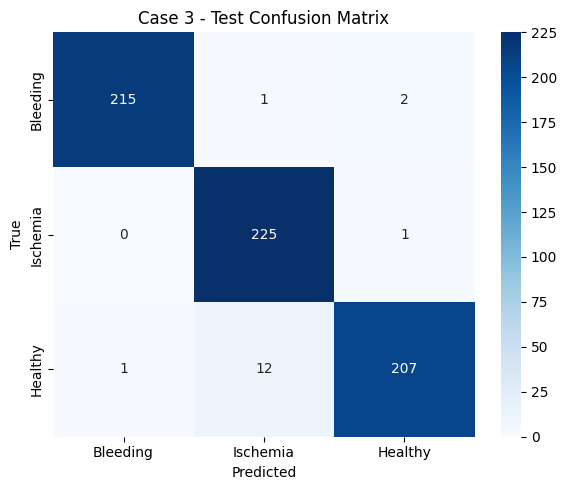


🔍 Αξιολόγηση Μοντέλου 4 (Fold 4)
Accuracy: 0.962349 | Precision: 0.963186 | Recall: 0.962349 | F1: 0.962415


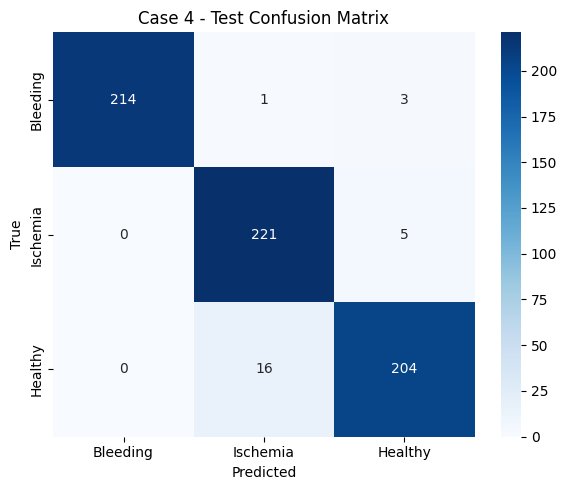

In [ ]:
print_confusion_matrixes(
    arch_name="densnet121",
    model_dir="/content/drive/My Drive/Neural Networks/DensNet121",
    model_fn=densenet121_model,
    val_transform=val_transform,
    load_fold_data=load_fold_data,
    evaluate_model=evaluate_model,
    save_metrics_to_csv=save_metrics_to_csv
)

#**Accuracy and Loss Curves**

In [ ]:
# Load metrics from CSV
def load_metrics_from_csv(csv_path, model_idx):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}")
    df = pd.read_csv(csv_path)
    model_df = df[df['model'] == model_idx]
    if model_df.empty:
        raise ValueError(f"No data found for Model {model_idx} in {csv_path}")
    return {
        'train_losses': model_df['loss'].tolist(),
        'val_losses': model_df['val_loss'].tolist(),
        'train_accuracies': model_df['accuracy'].tolist(),
        'val_accuracies': model_df['val_accuracy'].tolist(),
        'epochs': model_df['epoch'].tolist()
    }

def plot_combined_curve(train_losses, val_losses, train_accuracies, val_accuracies, epochs, model_idx, base_path):
    plt.figure(figsize=(16, 5))  # Double width for side-by-side plots

    # Loss subplot (left)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'Case {model_idx} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy subplot (right)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title(f'Case {model_idx} - Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    os.makedirs(base_path, exist_ok=True)
    plt.savefig(os.path.join(base_path, f"model_{model_idx}_combined_curve.png"))
    plt.show()
    plt.close()

# Generate plots for all models
def generate_plots_for_all_models(csv_path, plots_path):
    for model_idx in range(5):  # Models 0-4
        try:
            metrics = load_metrics_from_csv(csv_path, model_idx)
            plot_combined_curve(
                metrics['train_losses'], metrics['val_losses'],
                metrics['train_accuracies'], metrics['val_accuracies'],
                metrics['epochs'], model_idx, plots_path
            )
            print(f"Generated combined plot for Model {model_idx}")
        except (FileNotFoundError, ValueError) as e:
            print(f"Error for Model {model_idx}: {e}")

Accuracy and Loss Curves - ResNet50

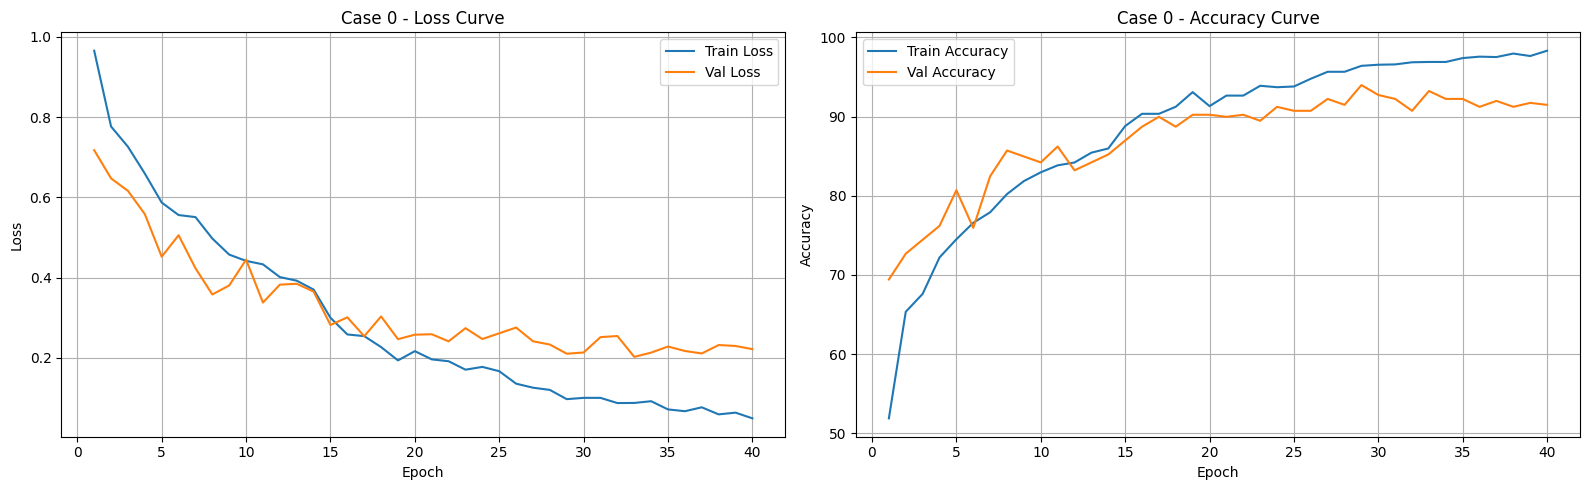

Generated combined plot for Model 0


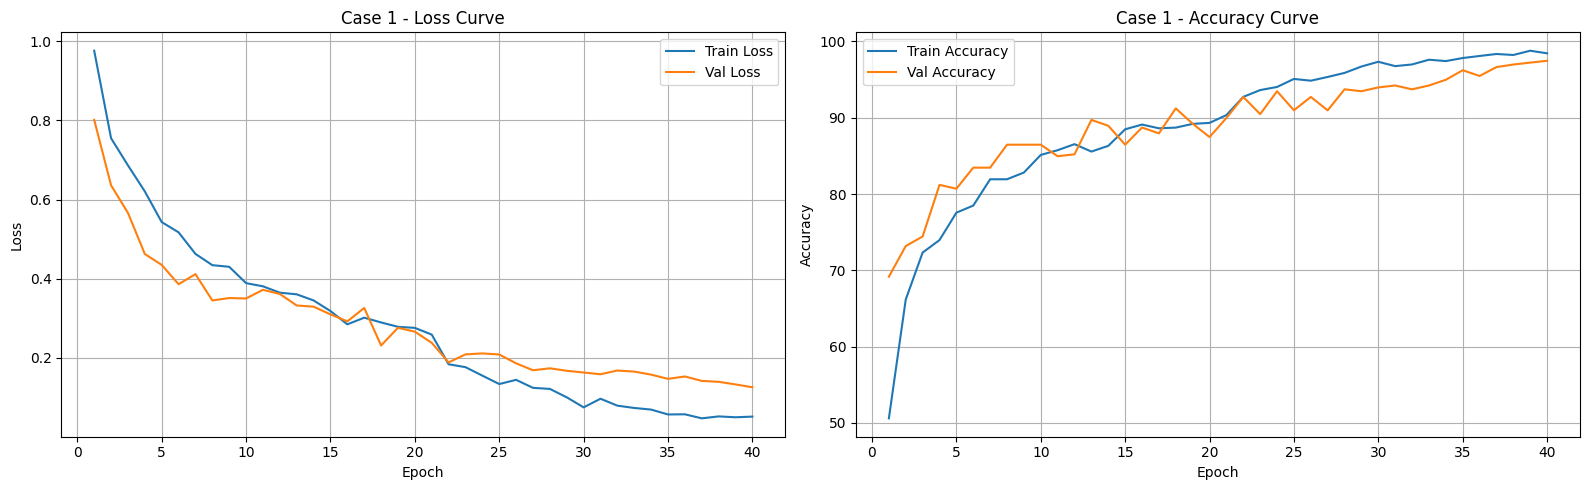

Generated combined plot for Model 1


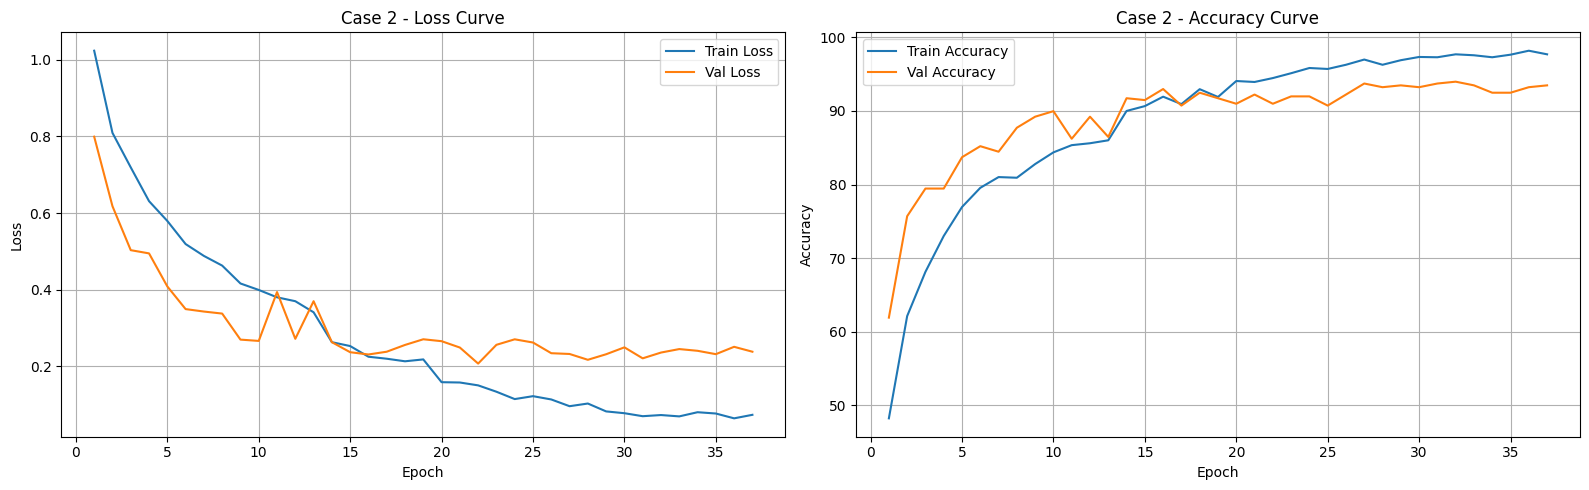

Generated combined plot for Model 2


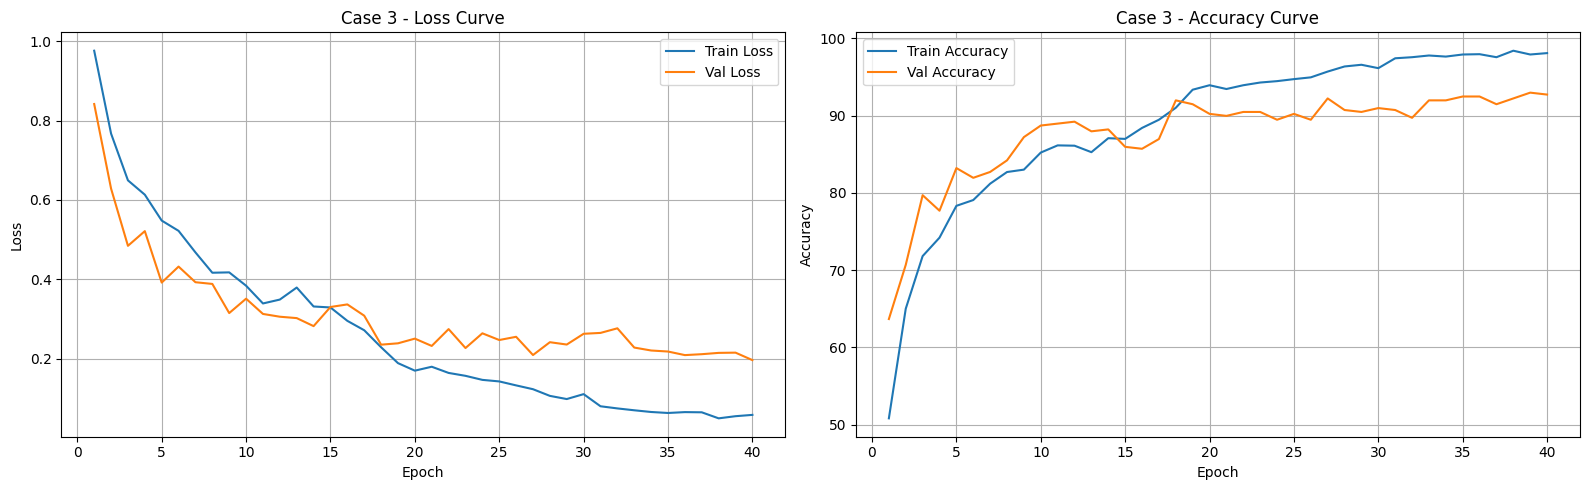

Generated combined plot for Model 3


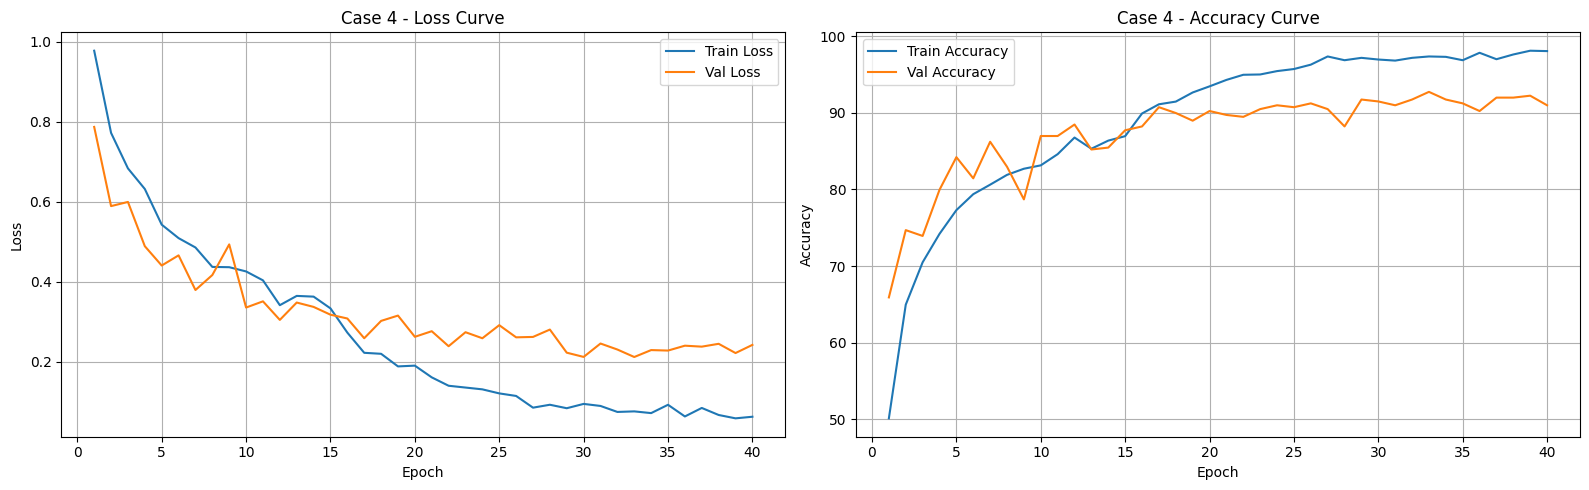

Generated combined plot for Model 4


In [ ]:
base_path = "/content/drive/My Drive/Neural Networks/ResNet50"
csv_filename = "resnet_train_data.csv"
csv_path = os.path.join(base_path, csv_filename)
plots_path = os.path.join(base_path, "plots")

generate_plots_for_all_models(csv_path, plots_path)

Accuracy and Loss Curves - EfficientNet-B0

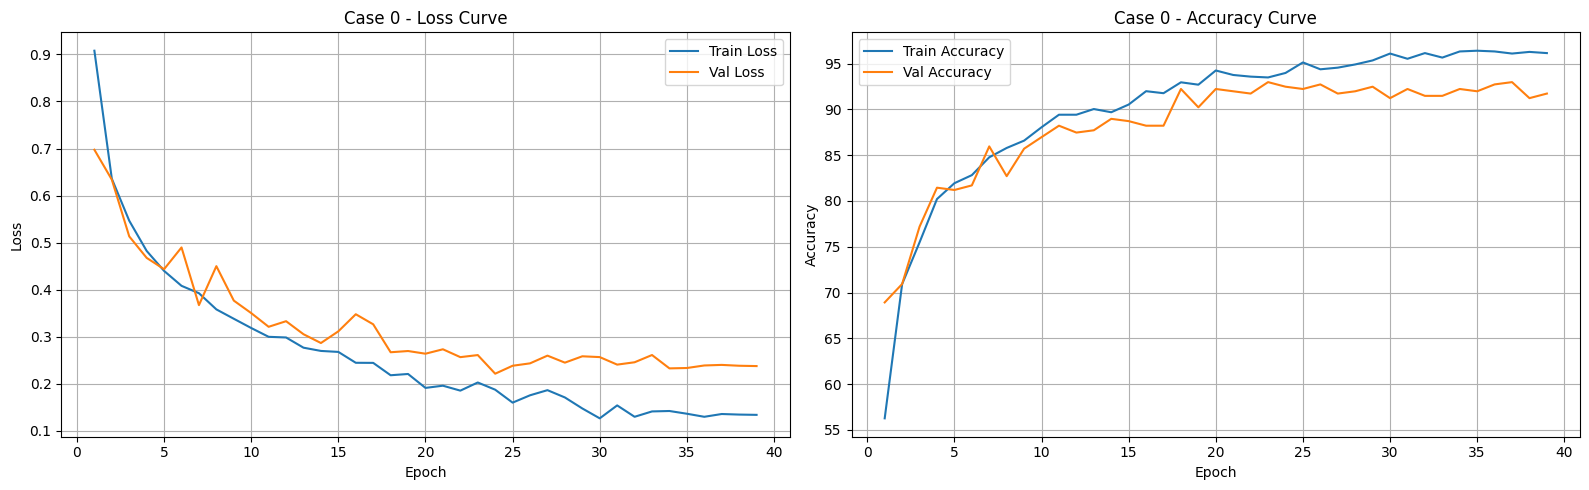

Generated combined plot for Model 0


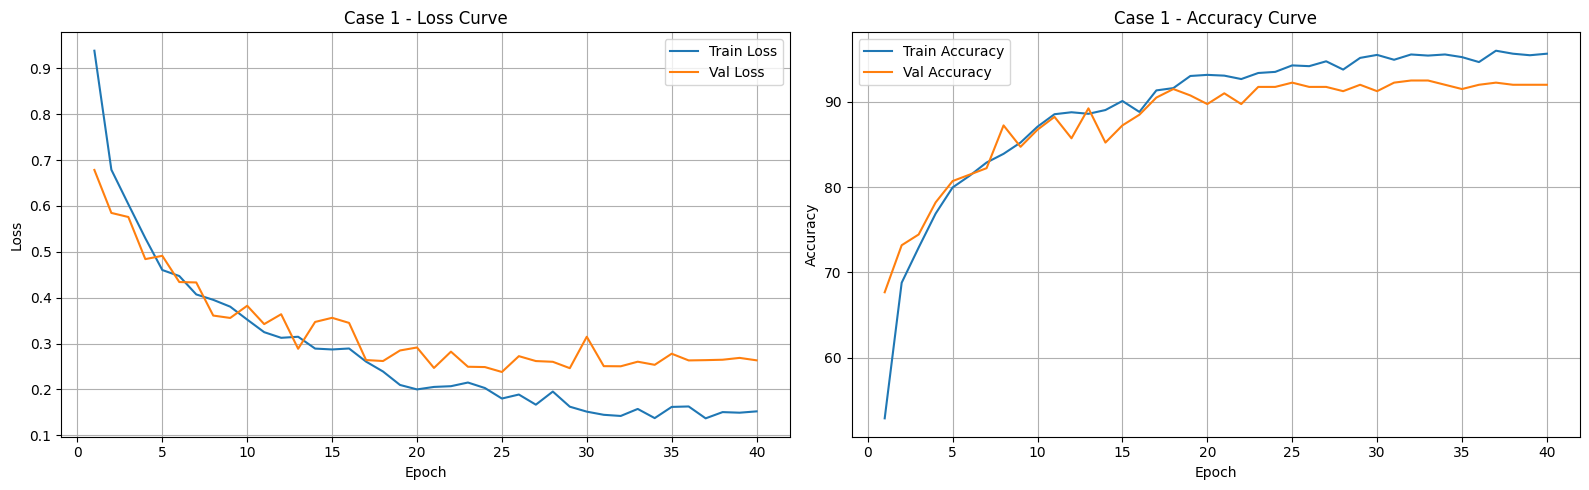

Generated combined plot for Model 1


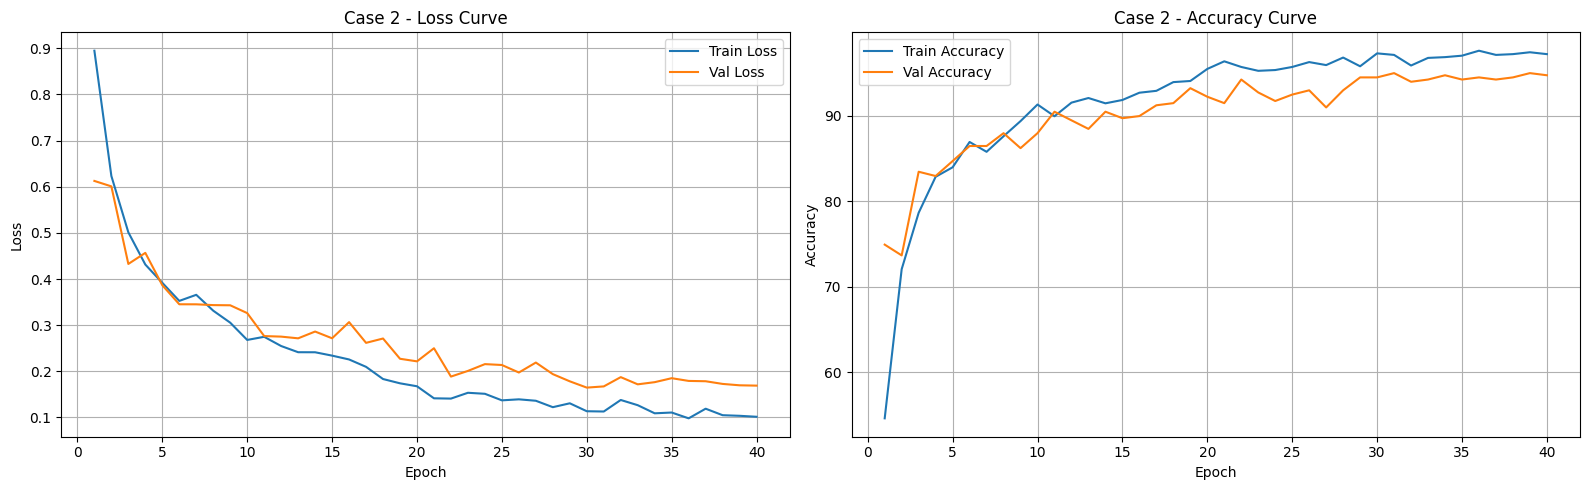

Generated combined plot for Model 2


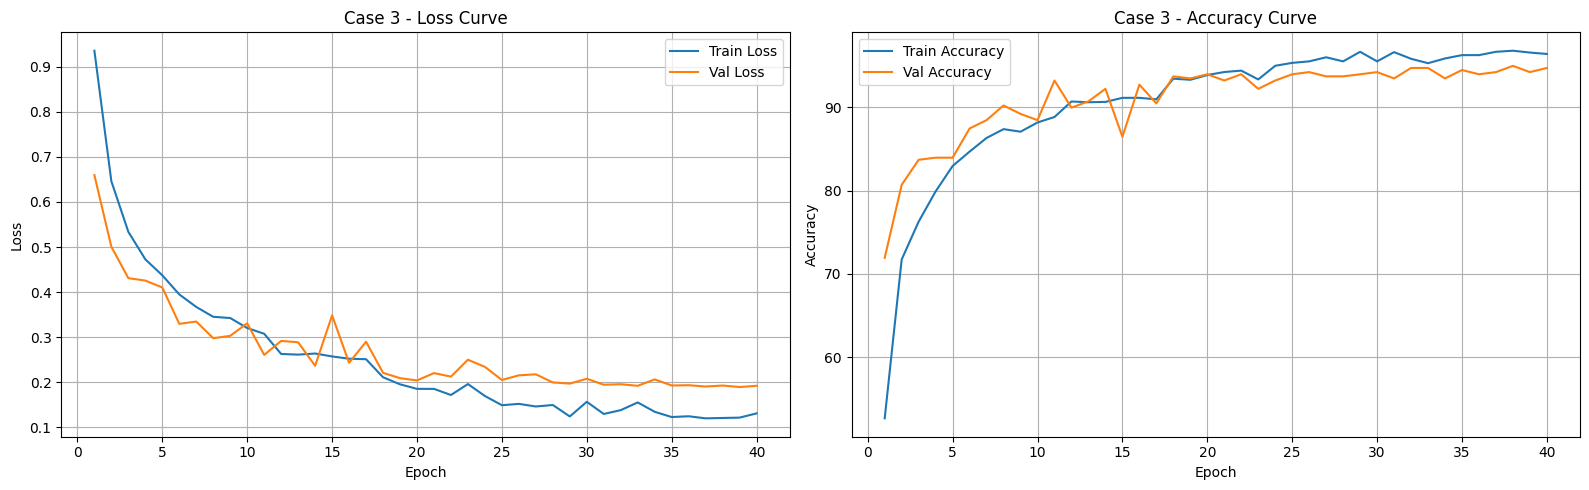

Generated combined plot for Model 3


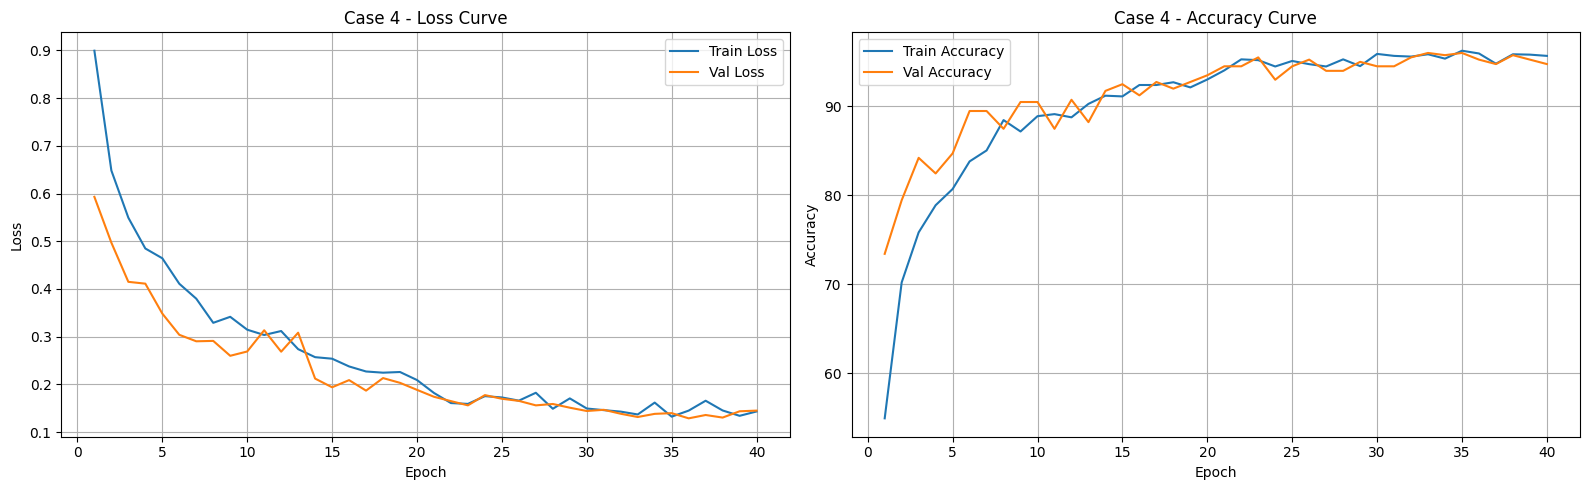

Generated combined plot for Model 4


In [ ]:
base_path = "/content/drive/My Drive/Neural Networks/EfficientNetB0"
csv_filename = "efficientnet_train_data.csv"
csv_path = os.path.join(base_path, csv_filename)
plots_path = os.path.join(base_path, "plots")

generate_plots_for_all_models(csv_path, plots_path)